# What is stable Diffusion?
https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb

## Latents and Callbacks
- Diffusion Models are used for generating image data.
- Diffusion Models are slow while performing reverse diffusion
- Also, they consume lot of memory because they operate in pixel space, which is expensive for high resolution images.
- Training and Inference is difficult

*Latent Diffusion*
- Helps to reduce memory and compute complexity
- This is done by applying diffusion process over lower dimenensional latent space
- In latent diffusion the model is trained to generate latent (compressed) representation of images.


In [1]:
import torch
from diffusers import StableDiffusionPipeline

/home/agastya/mambaforge/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/agastya/mambaforge/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
pipe = StableDiffusionPipeline.from_pretrained("pcuenq/jh_dreambooth_1000", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
dir(pipe)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_best_guess_weight_name',
 '_callback_tensor_inputs',
 '_check_text_inv_inputs',
 '_deprecated_kwargs',
 '_dict_from_json_file',
 '_encode_prompt',
 '_exclude_from_cpu_offload',
 '_execution_device',
 '_extend_tokens_and_embeddings',
 '_get_init_keys',
 '_get_signature_keys',
 '_get_signature_types',
 '_internal_dict',
 '_is_onnx',
 '_load_connected_pipes',
 '_maybe_convert_prompt',
 '_optional_components',
 '_optionally_disable_offloading',
 '_remove_text_encoder_monkey_patch',
 '_retrieve_tokens_and_embeddings',
 '_upload_folder',
 'check_inputs',
 'clip_skip',
 'components',
 'config',
 'c

In [4]:
vae = pipe.vae
images = []

# Creating function to visualize the denoising for steps
def latents_callback(i, t, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample[0] # What does sample zero mean?

    image = image.cpu().permute(1,2,0).numpy()
    images.extend(pipe.numpy_to_pil(image))

In [5]:
from PIL import Image
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

/home/agastya/mambaforge/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:874: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
/home/agastya/mambaforge/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:880: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/50 [00:00<?, ?it/s]

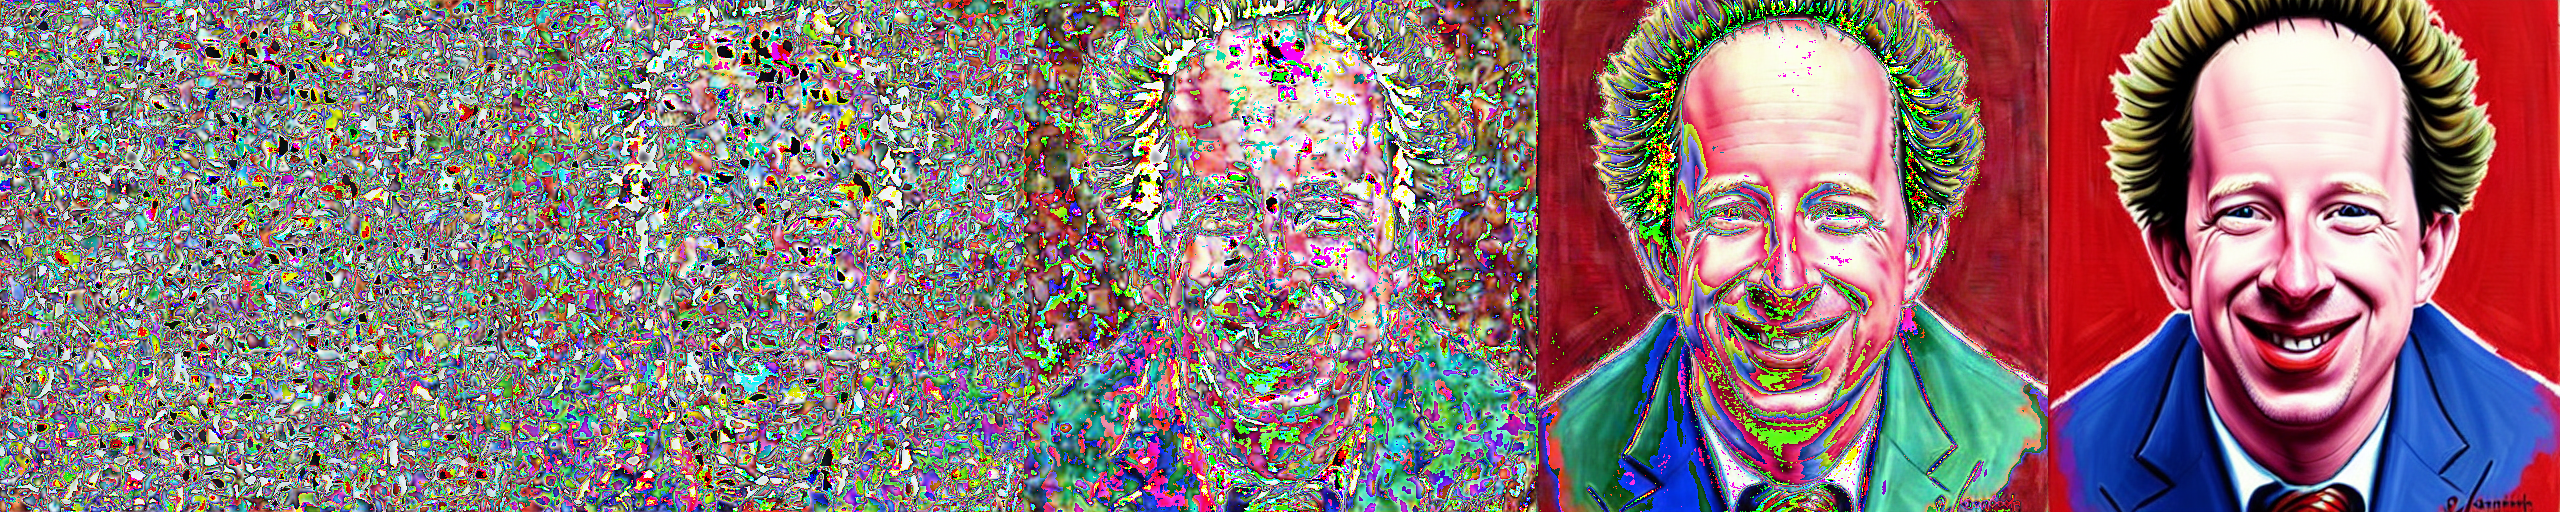

In [6]:
prompt = "Portrait painting of Jeremy Howard looking happy."
torch.manual_seed(9000)
final_image = pipe(prompt, callback=latents_callback, callback_steps=12).images[0]
images.append(final_image)
image_grid(images, rows=1, cols=len(images))

## Why is latent diffusion fast and efficient?
- U-Net of latent diffusion operates on low dimensional space, it greatly reduces the memory and compute.
- Auto Encoder has a reduction factor of 8 but uses 4 channel instead of 3 this means
  (3, 512, 512) -> (4, 64, 64)
- 8 * 8 * 3/4 = 48 Times less memory 

In [7]:
del pipe

# Looking inside the pipeline
Loading and plugging the model pieces and experimenting.
- We'll start by loading all the modules that we need from their pretrained weights.

- First, we need text encoder and tokenizer. These come from the text portion of the `CLIP` model. 

In [8]:
from transformers import CLIPTextModel, CLIPTokenizer

In [9]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = text_encoder.to('cuda')

/home/agastya/mambaforge/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
# Next we'll load the vae and the unet. These are distinct models whose weights are stored inside folders of the Stable Diffusion repository
from diffusers import AutoencoderKL, UNet2DConditionModel

In [11]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

- Standard pipeline uses the PNDM Scheduler, but we'll use K-LMS Scheduler
- We need to be careful to use the same noising schedule that was used during training.
- The schedule is defined by number of noising step and amount of noise step added at each step, which is derived from the beta parameters

In the case of the k-LMS scheduler, this is how the betas evolve during the 1000 steps of the noising process used during training:

Text(0, 0.5, 'Beta')

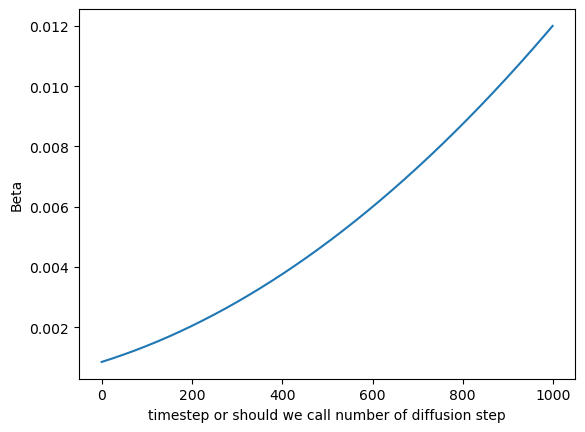

In [12]:
from matplotlib import pyplot as plt
beta_start, beta_end = 0.00085, 0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('timestep or should we call number of diffusion step')
plt.ylabel('Beta')

In [13]:
from diffusers import LMSDiscreteScheduler

In [14]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end,
                                 beta_schedule="scaled_linear", num_train_timesteps=1000)

In contrast with the previous examples, we set num_inference_steps to 70 to get an even more defined image.

In [15]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

We tokenize the prompt. The model requires the same number of tokens for every prompt (77 token size support), so padding is used to ensure we meet the required length.

In [16]:
text_input = tokenizer(prompt, padding='max_length', max_length = tokenizer.model_max_length,
                        truncation=True, return_tensors="pt")

In [17]:
text_input

{'input_ids': tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [18]:
text_input['input_ids'].shape

torch.Size([1, 77])

In [19]:
tokenizer.decode(49407), tokenizer.decode(8853)

('<|endoftext|>', 'photograph')

In [20]:
# The attention mask uses zero to represent tokens we are not interested in. These are all of the padding tokens.
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

In [21]:
text_embeddings = text_encoder(text_input.input_ids.to('cuda'))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

We also get the embeddings required to perform unconditional generation, which is achieved with an empty string: the model is free to go in whichever direction it wants as long as it results in a reasonably-looking image. These embeddings will be applied to apply classifier-free guidance.

In [22]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([''] * batch_size,
                         padding = "max_length",
                         max_length=max_length,
                         return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to('cuda'))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

In [23]:
max_length

77

For classifier-free guidance, we need to do two forward passes. One with the conditioned input(text_embedding) and another with the uncoditional text embeddings(uncond_embedding). In practice, we concatenate both into a single batch to avoid two forward passes.
- Prompt for image
- Guidance prompt (eg: negative prompting, or unconditioned prompt (random embedding))

In [24]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings.shape

torch.Size([2, 77, 768])

In [25]:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.in_channels, height//8, width//8))
latents = latents.to('cuda').half()
latents.shape

/tmp/ipykernel_25605/1465962905.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8))


torch.Size([1, 4, 64, 64])

`4x64x64` is the input shape. The decoder will later transform this latent representation into `3x512x512` image after the denoising is complete.
Next, we initialize the scheduler with our chosen num_inference_steps. This will prepare the internal state to be used during denoising.

In [26]:
scheduler.set_timesteps(num_inference_steps)

we scale the initial noise by the standard deviation required by the scheduler. The value will depend on the particular scheduler that we use.

In [27]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop. The timesteps go from 999 to 0 (1000 steps that were used during training) following a particular schedule.

In [28]:
scheduler.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3044, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9131, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0869, 260.6087, 246.1304, 231.6522, 217.1739, 202.6956,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3044, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000])

In [29]:
scheduler.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

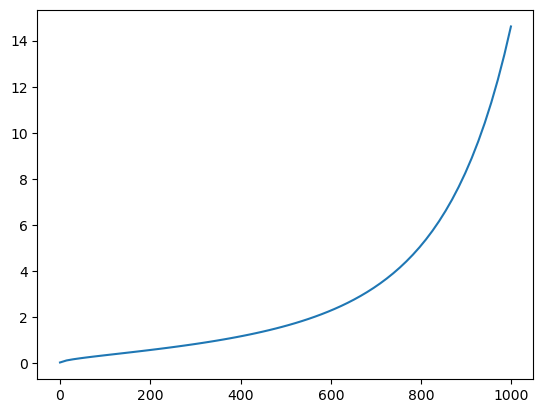

In [30]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

In [31]:
from tqdm.auto import tqdm
for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

After this process complets our latents contain the denoised representation of the image. We use the vae decoder to convert it back to pixel space

In [32]:
with torch.no_grad(): image = vae.decode(1/0.18215 * latents).sample

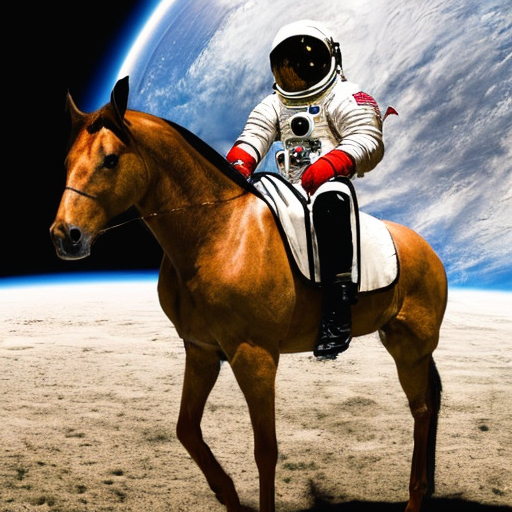

In [33]:
# Converting image to PIL so  we can display it
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

## Just the code

In [34]:
prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

In [35]:
text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [36]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * len(prompts), padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
emb = torch.cat([uncond_embeddings, text_embeddings])

In [37]:
torch.manual_seed(100)
g = guidance_scale
g

7.5

In [38]:
latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8))
scheduler.set_timesteps(num_inference_steps)
latents = latents.to("cuda").half() * scheduler.init_noise_sigma

/tmp/ipykernel_25605/2666912063.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8))


In [39]:
latents.shape

torch.Size([2, 4, 64, 64])

In [40]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [41]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
res = (image / 2 + 0.5).clamp(0, 1)

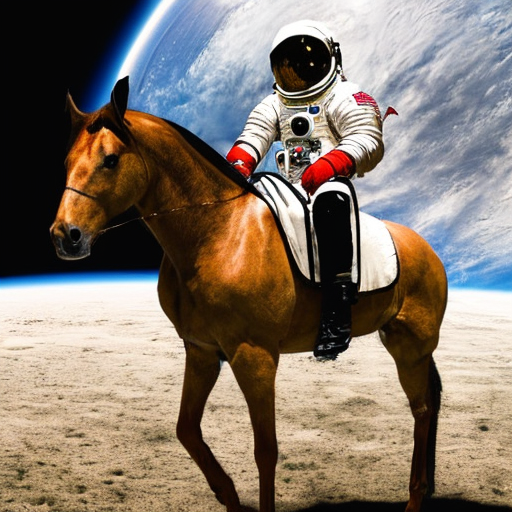

In [42]:
image = res[0].detach().cpu().permute(1,2,0).numpy()
image = (image*255).round().astype('uint8')
Image.fromarray(image)

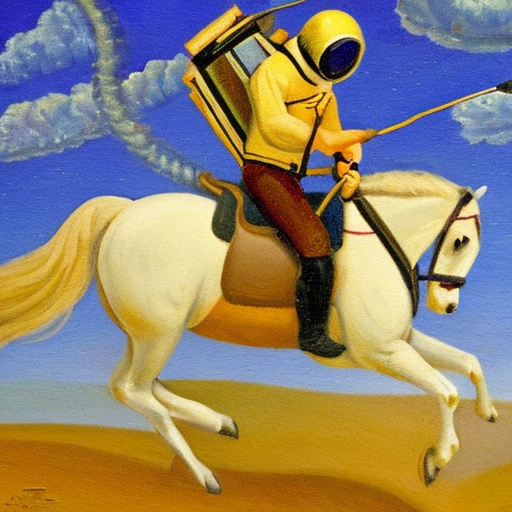

In [43]:
image = res[1].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

## Put it in functions

In [44]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors='pt')
    return text_encoder(inp.input_ids.to("cuda"))[0].half()


def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [45]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample
        
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [46]:
images = mk_samples(prompts)

/tmp/ipykernel_25605/3551474858.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

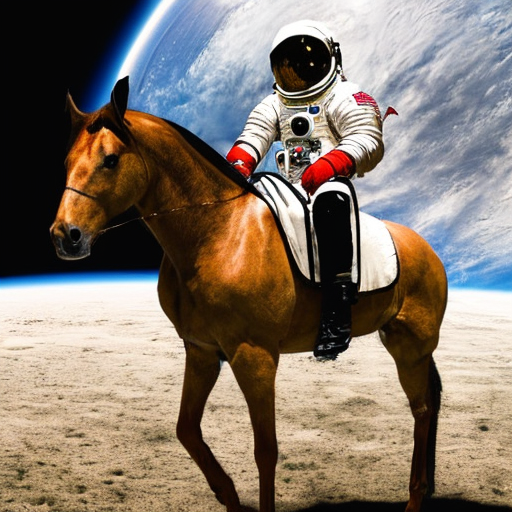

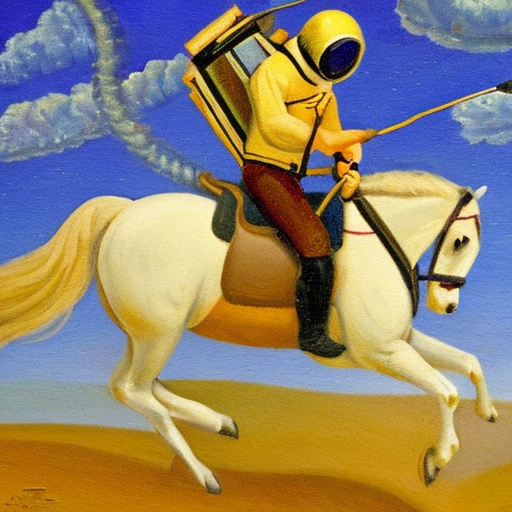

In [47]:
from IPython.display import display
for img in images: display(mk_img(img))

In [54]:
unet()

TypeError: UNet2DConditionModel.forward() missing 3 required positional arguments: 'sample', 'timestep', and 'encoder_hidden_states'

https://realpython.com/python-callable-instances/